In [1]:
!pip install fastdtw
!pip install imblearn
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542091 sha256=062252dd7421009b90d8088762755abbb5cb16b8d681a39afee14fc568eea768
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 1.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score
from urllib.request import urlopen
from io import StringIO
from google.colab import drive
import random
from imblearn.metrics import specificity_score
from tslearn.preprocessing import TimeSeriesResampler

In [3]:
# 1. Google Drive 마운트 및 데이터 파일 경로 설정
drive.mount('/content/drive')
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample.csv')

X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)

Mounted at /content/drive


In [4]:
# Identify minority class
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

In [5]:
# Extract minority class samples
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [6]:
# Generate synthetic time series using DTW-based random walk
def generate_dtw_synthetic_data(X, num_samples):
    synthetic_data = []
    for _ in range(num_samples):
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)
        dtw_avg = (X[idx1] + X[idx2]) / 2  # Simple average as DTW-based augmentation
        synthetic_data.append(dtw_avg)
    return np.array(synthetic_data)
nCnt = len(X_train)-len(X_minority)
#X_synthetic = generate_dtw_synthetic_data(X_minority, num_samples=len(X_minority))
X_aug = generate_dtw_synthetic_data(X_minority, num_samples=nCnt)
y_aug = np.full(len(X_aug), minority_class)

In [7]:
X_synthetic = np.concatenate((X_train, X_aug), axis=0)
y_synthetic = np.concatenate((y_train, y_aug), axis=0)

In [8]:
# 3. DTW 거리 행렬 계산 함수 정의 (1D 벡터 변환 추가)
def compute_dtw_matrix(X1, X2):
    """X1과 X2 간의 DTW 거리 행렬을 계산"""
    n1, n2 = len(X1), len(X2)
    dtw_matrix = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            distance, _ = fastdtw(X1[i].reshape(-1, 1), X2[j].reshape(-1, 1), dist=euclidean)
            dtw_matrix[i, j] = distance
    return dtw_matrix

In [9]:
# 4. DTW 거리 행렬 계산
print("Computing DTW distance matrix for training data...")
train_dtw_matrix = compute_dtw_matrix(X_synthetic, X_synthetic)
print("Computing DTW distance matrix between train and test data...")
test_dtw_matrix = compute_dtw_matrix(X_test, X_synthetic)

Computing DTW distance matrix for training data...
Computing DTW distance matrix between train and test data...


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
# train 점수
k_range = range(1, 21)  # K 값을 1부터 20까지 탐색
trainList = []
for k in k_range:
    # 모델 선택 및 하이퍼 파라미터 튜닝
    #model = KNeighborsClassifier(n_neighbors = k, metric='precomputed')
    model = KNeighborsClassifier(n_neighbors = k)
    # 모델학습
    model.fit(train_dtw_matrix, y_synthetic)
    scores = cross_val_score(model, train_dtw_matrix, y_synthetic, cv=5, scoring='f1_macro')
    trainList.append(scores.mean())
optimal_score = trainList[np.argmax(trainList)]
optimal_k = np.argmax(trainList)+1
print(f"최적의 K 값: {optimal_k}")
print(f"최적의 K 값의 성능: {optimal_score}")

최적의 K 값: 1
최적의 K 값의 성능: 0.937327338836818


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

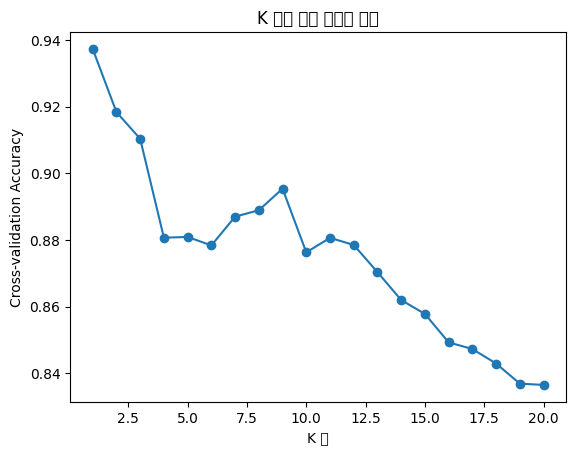

In [11]:
# K 값에 따른 정확도 그래프
plt.plot(k_range, trainList, marker='o')
plt.xlabel("K 값")
plt.ylabel("Cross-validation Accuracy")
plt.title("K 값에 따른 정확도 변화")
plt.show()

In [12]:
print(train_dtw_matrix.shape)
print(y_synthetic.shape)
print(train_dtw_matrix.shape)


(480, 480)
(480,)
(480, 480)


In [13]:
# 최적 K 값으로 최종 KNN 모델 학습 및 평가
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(train_dtw_matrix, y_synthetic)
y_pred = knn_optimal.predict(test_dtw_matrix)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve

In [15]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"specificity: {specificity:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7059
F1 Score: 0.6456
Recall: 0.9643
specificity: 0.2069
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.21      0.32        29
           1       0.70      0.96      0.81        56

    accuracy                           0.71        85
   macro avg       0.73      0.59      0.57        85
weighted avg       0.72      0.71      0.65        85



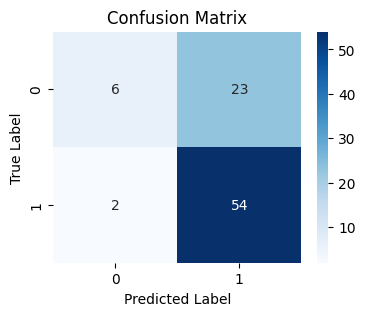

In [16]:
# Confusion Matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()